## **Trash Sorting Classification using ConvNeXt Tiny**

### **Project Setup**

In [1]:
# Download necessary libraries
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn pillow opencv-python tqdm

In [2]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Import libraries
import os
from pathlib import Path
from collections import Counter
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ConvNeXtTiny # Main pre-trained model
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import kagglehub

### **Data Loading**

**Download Dataset from Kaggle**

In [4]:
# Download latest version of data
path = kagglehub.dataset_download("mostafaabla/garbage-classification")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'garbage-classification' dataset.
Path to dataset files: /kaggle/input/garbage-classification


In [5]:
# Check the directories inside the path
print(os.listdir(path))

['garbage_classification']


**Setup Configuration**

In [6]:
# Define base directory
BASE_DIR = "/content/drive/MyDrive/machine_learning_final_project"

# List directory
print(os.listdir(BASE_DIR))

['trash_sorting_convnexttiny_training.ipynb', 'garbage_classification', 'trash_sorting_preprocessing.ipynb', 'trash_sorting_efficientnetb0_training.ipynb', 'preprocessed_data', 'trash_sorting_mobilenetV2.ipynb', 'trash_sorting_efficientnetv2.ipynb', 'checkpoints']


In [7]:
# Define the dataset directory
DATA_DIR = "/root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1/garbage_classification"

# Setup up configuration for global constant variables
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

EPOCHS_BASELINE = 10
EPOCHS_STAGE1 = 10   # For classifier head
EPOCHS_STAGE2 = 10   # For trasnfer learning layers

**Collect Image Paths and Labels**

In [8]:
# Define data path
data_path = Path(DATA_DIR)

# Sort class names from the main directory
class_names = sorted([d.name for d in data_path.iterdir() if d.is_dir()])

# Create class index
class_to_idx = {name: i for i, name in enumerate(class_names)}
num_classes = len(class_names)

print("Classes:", class_names)
print("Num classes:", num_classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Num classes: 12


In [9]:
# Define path and labels
paths = []
labels = []

for class_name in class_names:
    class_dir = data_path / class_name

    for img_path in class_dir.glob("*.*"):
        paths.append(str(img_path))
        labels.append(class_to_idx[class_name])

paths = np.array(paths)
labels = np.array(labels)

print("Total images: ", len(paths))

Total images:  15515


**Quck Image Visualization**

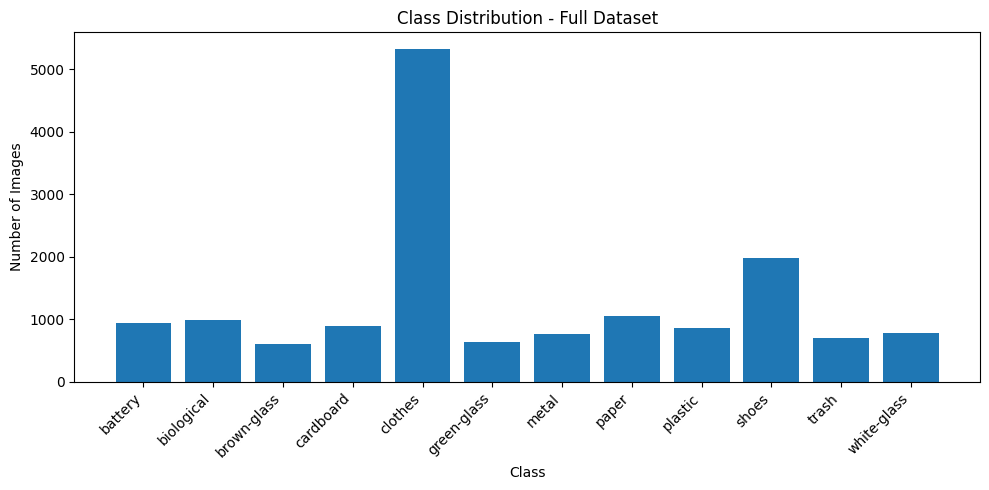

In [10]:
# Class distribution
counts = Counter(labels)
counts_list = [counts[i] for i in range(num_classes)]

plt.figure(figsize=(10, 5))
plt.bar(class_names, counts_list)
plt.xticks(rotation=45, ha="right")
plt.title("Class Distribution - Full Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

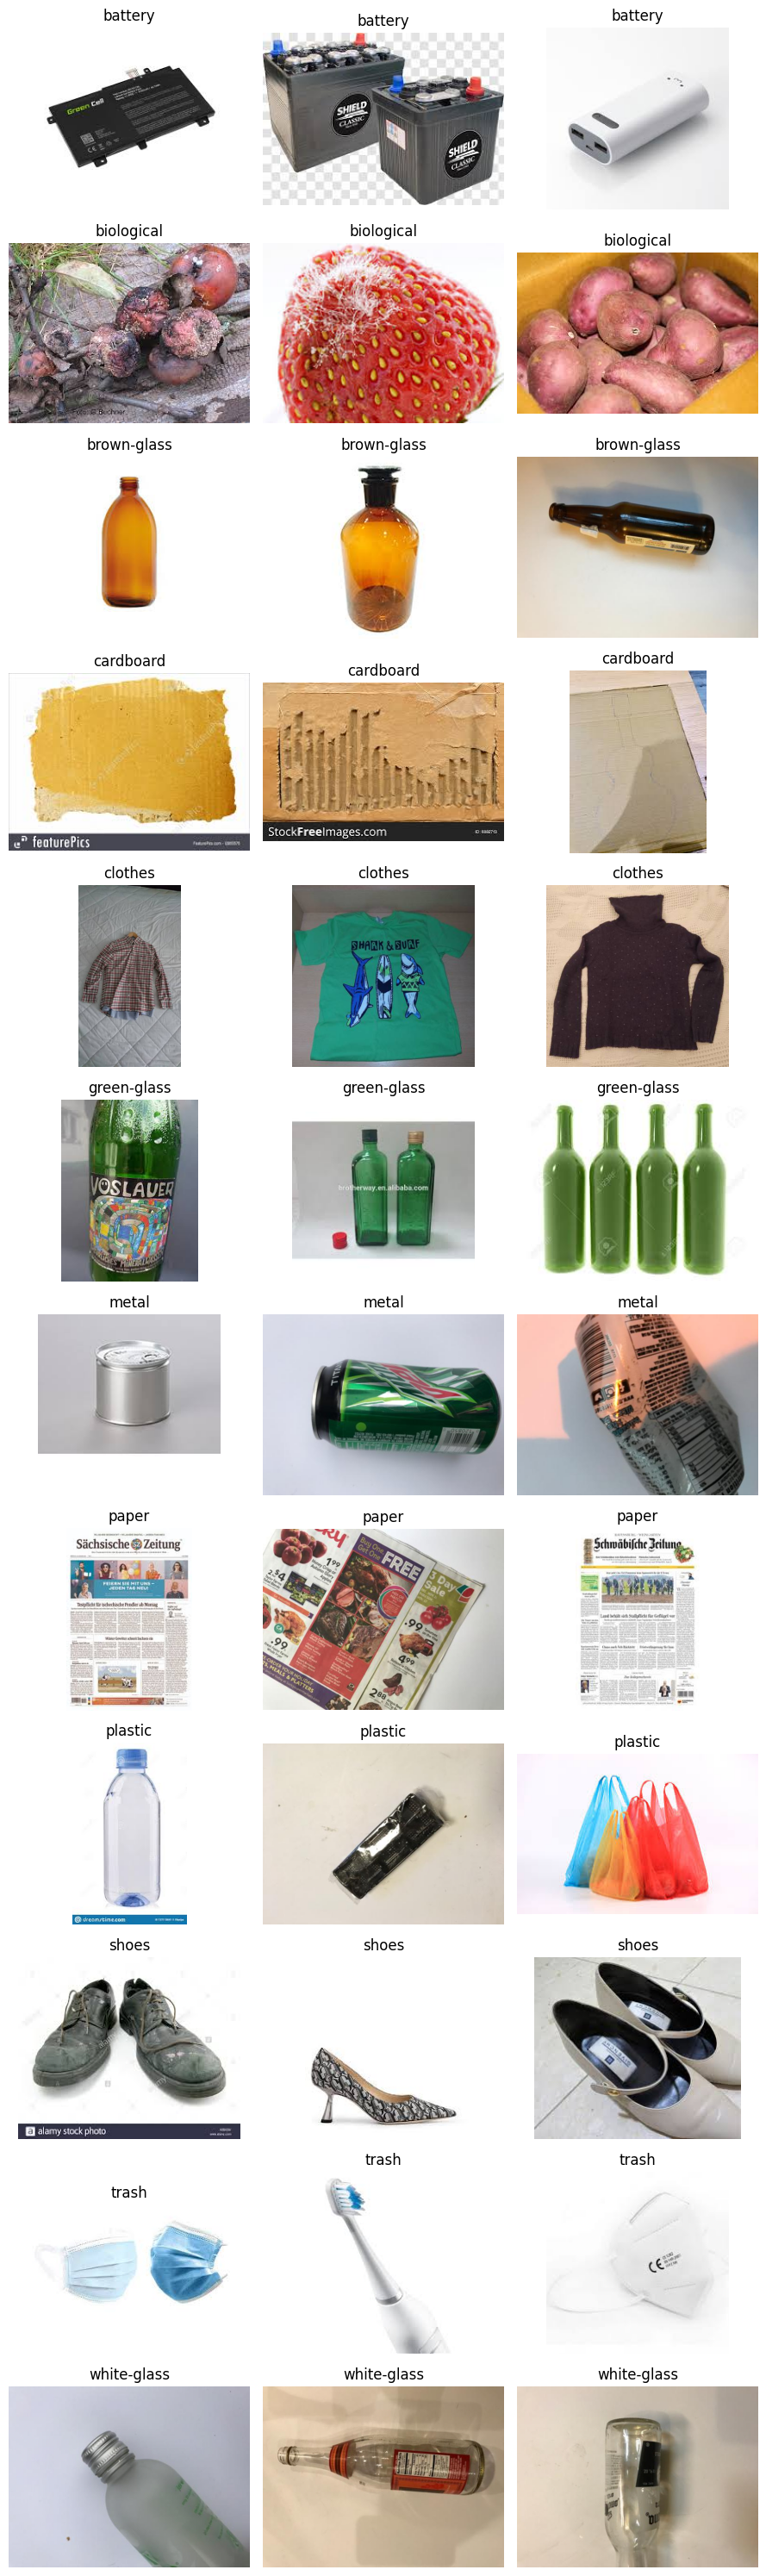

In [11]:
# Visualize the classes images
n_samples_per_class = 3

n_cols = n_samples_per_class
n_rows = num_classes

plt.figure(figsize=(3 * n_cols, 2.5 * n_rows))

for row, cname in enumerate(class_names):
    # Get indices for this class
    class_idx = class_to_idx[cname]
    indices = [i for i, lbl in enumerate(labels) if lbl == class_idx]
    # Pick random samples
    sample_indices = random.sample(indices, min(n_samples_per_class, len(indices)))

    for col, idx in enumerate(sample_indices):
        img_path = paths[idx]
        img = Image.open(img_path).convert("RGB")

        ax = plt.subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(img)
        ax.set_title(cname)
        ax.axis("off")
        if col == 0:
            ax.set_ylabel(cname, rotation=0, labelpad=40, fontsize=10, va="center")

plt.tight_layout()
plt.show()

### **Data Preparation**

**Data Splitting**

In [12]:
# Split the dataset into train/val/test - 70/15/15
paths_train, paths_temp, labels_train, labels_temp = train_test_split(
    paths,
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=SEED
)

# Split on temp (val/test)
paths_val, paths_test, labels_val, labels_test = train_test_split(
    paths_temp,
    labels_temp,
    test_size=0.5,
    stratify=labels_temp,
    random_state=SEED
)

print("Train:", len(paths_train))
print("Val:", len(paths_val))
print("Test:", len(paths_test))

Train: 10860
Val: 2327
Test: 2328


**Class Weights**

In [13]:
# Compute class weights for training set only
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_train),
    y=labels_train
)

class_weight = {i: w for i, w in enumerate(class_weights_array)}
print("Class weights:", class_weight)

Class weights: {0: np.float64(1.3691376701966718), 1: np.float64(1.3134978229317853), 2: np.float64(2.1294117647058823), 3: np.float64(1.4503205128205128), 4: np.float64(0.24282264555943117), 5: np.float64(2.0568181818181817), 6: np.float64(1.6821561338289963), 7: np.float64(1.2312925170068028), 8: np.float64(1.4933993399339933), 9: np.float64(0.6539017341040463), 10: np.float64(1.8545081967213115), 11: np.float64(1.6666666666666667)}


**Build TensforFlow Dataset**

In [14]:
# Set autotune for optimal performance setting for data pipelines
AUTOTUNE = tf.data.AUTOTUNE

# Define a function to decode and resize images
def decode_and_resize(path, label):

    # Read file path
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)

    return img, label


# Define a function to make the dataset
def make_dataset(paths, labels, shuffle=False):

    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)

    # Decode and resize the image
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return ds

In [15]:
# Create train, test, and val dataset
train_ds = make_dataset(paths_train, labels_train, shuffle=True)
val_ds   = make_dataset(paths_val,   labels_val,   shuffle=False)
test_ds  = make_dataset(paths_test,  labels_test,  shuffle=False)

**Data Augmentation**

In [16]:
# Create data augmentation pipeline
data_augmentation = tf.keras.Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(height_factor=(-0.2, -0.3), interpolation = 'bilinear'),
      layers.RandomContrast(factor=0.1),
      layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name = "data_augmentation",
)

### **ConvNeXt Tiny Transfer Learning**

**Build Base Model**

In [17]:
# Define a function to build the base model
def build_base_model(img_size=IMG_SIZE, num_classes=num_classes, dropout_rate=0.3):

    # Define the ConvNeXt Tiny model
    base_model = ConvNeXtTiny(
        include_top=False, # Exclude the classifier head
        weights="imagenet",
        input_shape=(img_size, img_size, 3),
    )
    base_model.trainable = False  # Stage 1: frozen

    # Create the layers
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # Apply data augmentation
    x = data_augmentation(inputs)

    # Preprocessing
    x = convnext_preprocess(x)
    x = base_model(x, training=False)

    # Apply average pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Create the model
    model = models.Model(inputs, outputs, name="convnext_tiny_base")

    return model, base_model

In [18]:
# Build the base model
dropout_rate = 0.3
model, base = build_base_model(dropout_rate=dropout_rate)

# Check the model
model.summary()

Model: "convnext_tiny_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │         9,228 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,829,356 (106.16 MB)

 Trainable params: 9,228 (36.05 KB)

 Non-trainable params: 27,820,128 (106.13 MB)

In [19]:
# Define the directory to save the checkpoint
CKPT_DIR = os.path.join(BASE_DIR, "checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

In [ ]:
# Stage 1: Train the classifier head only
lr_stage1 = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_stage1),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Define checkpoitn path
stage1_ckpt_path = os.path.join(CKPT_DIR, "convnext_stage1_head.keras")

# Callbacks for Stage 1
cb_stage1 = [
    EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-6),
    ModelCheckpoint(
        stage1_ckpt_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
]

# Train Stage 1
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    class_weight=class_weight,
    callbacks=cb_stage1,
    verbose=1,
)

Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.1907 - loss: 2.5058
Epoch 1: val_loss improved from inf to 1.42383, saving model to /content/drive/MyDrive/Machine Learning Final Project/checkpoints/convnext_stage1_head.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 171s 434ms/step - accuracy: 0.1911 - loss: 2.5050 - val_accuracy: 0.7069 - val_loss: 1.4238 - learning_rate: 1.0000e-04
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6300 - loss: 1.7019
Epoch 2: val_loss improved from 1.42383 to 0.97618, saving model to /content/drive/MyDrive/Machine Learning Final Project/checkpoints/convnext_stage1_head.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 131s 385ms/step - accuracy: 0.6302 - loss: 1.7015 - val_accuracy: 0.8191 - val_loss: 0.9762 - learning_rate: 1.0000e-04
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7671 - loss: 1.2540
Epoch 3: val_loss improved from 0.97618 to 0.75503, saving model to /content/drive/MyDrive/Machine Learning Final Projec

**Training Loop**

In [28]:
# Define the configuration for model setup Hyperparameter Tuning
configs = [
    {"fine_tune_layers": 20, "lr_stage2": 1e-4},
    {"fine_tune_layers": 20, "lr_stage2": 1e-5},
    {"fine_tune_layers": 30, "lr_stage2": 1e-4},
    {"fine_tune_layers": 30, "lr_stage2": 1e-5},
    {"fine_tune_layers": 40, "lr_stage2": 1e-4},
    {"fine_tune_layers": 40, "lr_stage2": 1e-5},
]

# Create a list to store results
results = []
best_model = None
best_score = -1
best_cfg = None
best_ckpt = None

In [ ]:
# Run the training loop
for cfg in configs:
    print(f"\n=== Training config: {cfg} ===")

    # Load the fixed Stage-1 model
    model = tf.keras.models.load_model(stage1_ckpt_path)

    #Get the ConvNeXt backbone
    base = None
    for layer in model.layers:
        if "convnext" in layer.name.lower():
            base = layer
            break

    # Unfreeze last N layers for this config
    base.trainable = True
    fine_tune_layers = cfg["fine_tune_layers"]
    fine_tune_at = len(base.layers) - fine_tune_layers

    for i, layer in enumerate(base.layers):
        layer.trainable = (i >= fine_tune_at)

    # Compile Stage 2 with this config's LR
    lr_stage2 = cfg["lr_stage2"]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_stage2),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Checkpoint path for this config
    ckpt_path = os.path.join(
        CKPT_DIR,
        f"convnext_ft{fine_tune_layers}_lr{lr_stage2:.0e}.keras"
    )

    callbacks_stage2 = [
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
        ModelCheckpoint(
            ckpt_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
        ),
    ]

    # Train Stage 2
    history_stage2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE1 + EPOCHS_STAGE2,
        initial_epoch=EPOCHS_STAGE1,
        class_weight=class_weight,
        callbacks=callbacks_stage2,
        verbose=1,
    )

    best_val_acc = max(history_stage2.history["val_accuracy"])
    print(f"→ val_acc = {best_val_acc:.4f}, checkpoint = {ckpt_path}")

    results.append({
        "config": cfg,
        "val_acc": best_val_acc,
        "ckpt_path": ckpt_path,
    })

    if best_val_acc > best_score:
        best_score = best_val_acc
        best_cfg = cfg
        best_ckpt = ckpt_path


=== Training config: {'fine_tune_layers': 20, 'lr_stage2': 0.0001} ===
Epoch 11/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 228s 620ms/step - accuracy: 0.9204 - loss: 0.3721 - val_accuracy: 0.9596 - val_loss: 0.1547 - learning_rate: 1.0000e-04
Epoch 12/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 200s 587ms/step - accuracy: 0.9618 - loss: 0.1596 - val_accuracy: 0.9648 - val_loss: 0.1316 - learning_rate: 1.0000e-04
Epoch 13/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 199s 586ms/step - accuracy: 0.9803 - loss: 0.0823 - val_accuracy: 0.9669 - val_loss: 0.1192 - learning_rate: 1.0000e-04
Epoch 14/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 202s 586ms/step - accuracy: 0.9860 - loss: 0.0561 - val_accuracy: 0.9695 - val_loss: 0.1042 - learning_rate: 1.0000e-04
Epoch 15/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 199s 586ms/step - accuracy: 0.9917 - loss: 0.0321 - val_accuracy: 0.9708 - val_loss: 0.1036 - learning_rate: 1.0000e-04
Epoch 16/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 199s 587ms/step - accuracy: 0.9935 - loss: 0.0252 - val_accuracy: 0.9703 - val_los

In [ ]:
# Define the configuration for model setup Hyperparameter Tuning
configs = [
    {"fine_tune_layers": 30, "lr_stage2": 1e-5},
    {"fine_tune_layers": 40, "lr_stage2": 1e-4},
    {"fine_tune_layers": 40, "lr_stage2": 1e-5},
]

# Create a list to store results
results = []
best_model = None
best_score = -1
best_cfg = None
best_ckpt = None

In [ ]:
# Get stage 1 checkpoint
stage1_ckpt_path = os.path.join(CKPT_DIR, "convnext_stage1_head.keras")

# Run the training loop
for cfg in configs:
    print(f"\n=== Training config: {cfg} ===")

    # Load the fixed Stage-1 model
    model = tf.keras.models.load_model(stage1_ckpt_path)

    #Get the ConvNeXt backbone
    base = None
    for layer in model.layers:
        if "convnext" in layer.name.lower():
            base = layer
            break

    # Unfreeze last N layers for this config
    base.trainable = True
    fine_tune_layers = cfg["fine_tune_layers"]
    fine_tune_at = len(base.layers) - fine_tune_layers

    for i, layer in enumerate(base.layers):
        layer.trainable = (i >= fine_tune_at)

    # Compile Stage 2 with this config's LR
    lr_stage2 = cfg["lr_stage2"]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_stage2),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Checkpoint path for this config
    ckpt_path = os.path.join(
        CKPT_DIR,
        f"convnext_ft{fine_tune_layers}_lr{lr_stage2:.0e}.keras"
    )

    callbacks_stage2 = [
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
        ModelCheckpoint(
            ckpt_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
        ),
    ]

    # Train Stage 2
    history_stage2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE1 + EPOCHS_STAGE2,
        initial_epoch=EPOCHS_STAGE1,
        class_weight=class_weight,
        callbacks=callbacks_stage2,
        verbose=1,
    )

    best_val_acc = max(history_stage2.history["val_accuracy"])
    print(f"→ val_acc = {best_val_acc:.4f}, checkpoint = {ckpt_path}")

    results.append({
        "config": cfg,
        "val_acc": best_val_acc,
        "ckpt_path": ckpt_path,
    })

    if best_val_acc > best_score:
        best_score = best_val_acc
        best_cfg = cfg
        best_ckpt = ckpt_path


=== Training config: {'fine_tune_layers': 30, 'lr_stage2': 1e-05} ===
Epoch 11/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 284s 770ms/step - accuracy: 0.9040 - loss: 0.4969 - val_accuracy: 0.9343 - val_loss: 0.2753 - learning_rate: 1.0000e-05
Epoch 12/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 256s 753ms/step - accuracy: 0.9223 - loss: 0.3616 - val_accuracy: 0.9411 - val_loss: 0.2382 - learning_rate: 1.0000e-05
Epoch 13/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 239s 703ms/step - accuracy: 0.9324 - loss: 0.2853 - val_accuracy: 0.9441 - val_loss: 0.2101 - learning_rate: 1.0000e-05
Epoch 14/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 239s 702ms/step - accuracy: 0.9401 - loss: 0.2530 - val_accuracy: 0.9471 - val_loss: 0.1935 - learning_rate: 1.0000e-05
Epoch 15/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 256s 753ms/step - accuracy: 0.9442 - loss: 0.2288 - val_accuracy: 0.9497 - val_loss: 0.1834 - learning_rate: 1.0000e-05
Epoch 16/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 239s 702ms/step - accuracy: 0.9507 - loss: 0.2021 - val_accuracy: 0.9570 - val_loss

**Evaluation**

In [20]:
# Define the model paths
configs = [
    {"fine_tune_layers": 20, "lr_stage2": "1e-04"},
    {"fine_tune_layers": 20, "lr_stage2": "1e-05"},
    {"fine_tune_layers": 30, "lr_stage2": "1e-04"},
    {"fine_tune_layers": 30, "lr_stage2": "1e-05"},
    {"fine_tune_layers": 40, "lr_stage2": "1e-04"},
    {"fine_tune_layers": 40, "lr_stage2": "1e-05"},
]

model_paths = {}

for cfg in configs:
    filename = f"convnext_ft{cfg['fine_tune_layers']}_lr{cfg['lr_stage2']}.keras"
    full_path = f"{CKPT_DIR}/{filename}"

    model_paths[filename] = full_path

print(model_paths)

{'convnext_ft20_lr1e-04.keras': '/content/drive/MyDrive/machine_learning_final_project/checkpoints/convnext_ft20_lr1e-04.keras', 'convnext_ft20_lr1e-05.keras': '/content/drive/MyDrive/machine_learning_final_project/checkpoints/convnext_ft20_lr1e-05.keras', 'convnext_ft30_lr1e-04.keras': '/content/drive/MyDrive/machine_learning_final_project/checkpoints/convnext_ft30_lr1e-04.keras', 'convnext_ft30_lr1e-05.keras': '/content/drive/MyDrive/machine_learning_final_project/checkpoints/convnext_ft30_lr1e-05.keras', 'convnext_ft40_lr1e-04.keras': '/content/drive/MyDrive/machine_learning_final_project/checkpoints/convnext_ft40_lr1e-04.keras', 'convnext_ft40_lr1e-05.keras': '/content/drive/MyDrive/machine_learning_final_project/checkpoints/convnext_ft40_lr1e-05.keras'}


In [32]:
# Load all the 6 models
saved_models = {}
for name, path in model_paths.items():
    saved_models[name] = tf.keras.models.load_model(path)

print(models)

<module 'keras.models' from '/usr/local/lib/python3.12/dist-packages/keras/models/__init__.py'>


In [24]:
# Evaluate each model of testing set
results = {}
for name, model in saved_models.items():
    test_loss_eff, test_acc_eff = model.evaluate(test_ds)
    print(f"=== Model: {name} ===")
    print(f"Model: {name} - Test Loss: {test_loss_eff:.4f}, Test Acc: {test_acc_eff:.4f}")
    print(f"Model: {name} - Test Acc: {test_acc_eff:.4f}")
    results[name] = test_acc_eff

73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - accuracy: 0.9875 - loss: 0.0473
=== Model: convnext_ft20_lr1e-04.keras ===
Model: convnext_ft20_lr1e-04.keras - Test Loss: 0.0516, Test Acc: 0.9858
Model: convnext_ft20_lr1e-04.keras - Test Acc: 0.9858
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 307ms/step - accuracy: 0.9609 - loss: 0.1229
=== Model: convnext_ft20_lr1e-05.keras ===
Model: convnext_ft20_lr1e-05.keras - Test Loss: 0.1268, Test Acc: 0.9622
Model: convnext_ft20_lr1e-05.keras - Test Acc: 0.9622
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - accuracy: 0.9844 - loss: 0.0477
=== Model: convnext_ft30_lr1e-04.keras ===
Model: convnext_ft30_lr1e-04.keras - Test Loss: 0.0490, Test Acc: 0.9850
Model: convnext_ft30_lr1e-04.keras - Test Acc: 0.9850
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - accuracy: 0.9659 - loss: 0.1149
=== Model: convnext_ft30_lr1e-05.keras ===
Model: convnext_ft30_lr1e-05.keras - Test Loss: 0.1168, Test Acc: 0.9665
Model: convnext_ft30_lr1e-05.keras - Test Acc: 0.9665
73/73 ━━━━━━━━━━

In [28]:
# Convert the result into dataframe
df = pd.DataFrame.from_dict(results, orient='index', columns=['Test Accuracy'])
df = df.sort_values(by='Test Accuracy', ascending=False)
df.head()

,Test Accuracy
convnext_ft40_lr1e-04.keras,0.988832
convnext_ft20_lr1e-04.keras,0.985825
convnext_ft30_lr1e-04.keras,0.984966
convnext_ft40_lr1e-05.keras,0.970790
convnext_ft30_lr1e-05.keras,0.966495


**Note:** Based on the evaluation result on the testing set above, we can see that ConvNeXt Tiny with learning rate of 0.0001 and number of layers set to 40 got the highest accuracy equal to `98.88%`.

In [29]:
# Save the evaluation score
evaluation_path = os.path.join(BASE_DIR, "evaluation.csv")
df.to_csv(evaluation_path)

In [33]:
# Define the final model
model = saved_models["convnext_ft40_lr1e-04.keras"]

# Get the classification report
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification report (EfficientNet on test set):\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
cm

Classification report (EfficientNet on test set):

              precision    recall  f1-score   support

     battery       0.98      1.00      0.99       142
  biological       1.00      0.99      1.00       148
 brown-glass       0.98      0.98      0.98        91
   cardboard       1.00      0.98      0.99       134
     clothes       1.00      0.99      0.99       799
 green-glass       1.00      1.00      1.00        94
       metal       0.98      0.96      0.97       115
       paper       0.96      1.00      0.98       158
     plastic       0.98      0.96      0.97       130
       shoes       0.98      1.00      0.99       297
       trash       1.00      0.98      0.99       104
 white-glass       0.97      0.99      0.98       116

    accuracy                           0.99      2328
   macro avg       0.99      0.99      0.99      2328
weighted avg       0.99      0.99      0.99      2328



array([[142,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 147,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,  89,   0,   0,   0,   1,   0,   0,   0,   0,   1],
       [  1,   0,   1, 131,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0, 793,   0,   0,   0,   0,   6,   0,   0],
       [  0,   0,   0,   0,   0,  94,   0,   0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,   0, 110,   1,   1,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0, 158,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   1,   3, 125,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0, 296,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0, 102,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0, 115]])

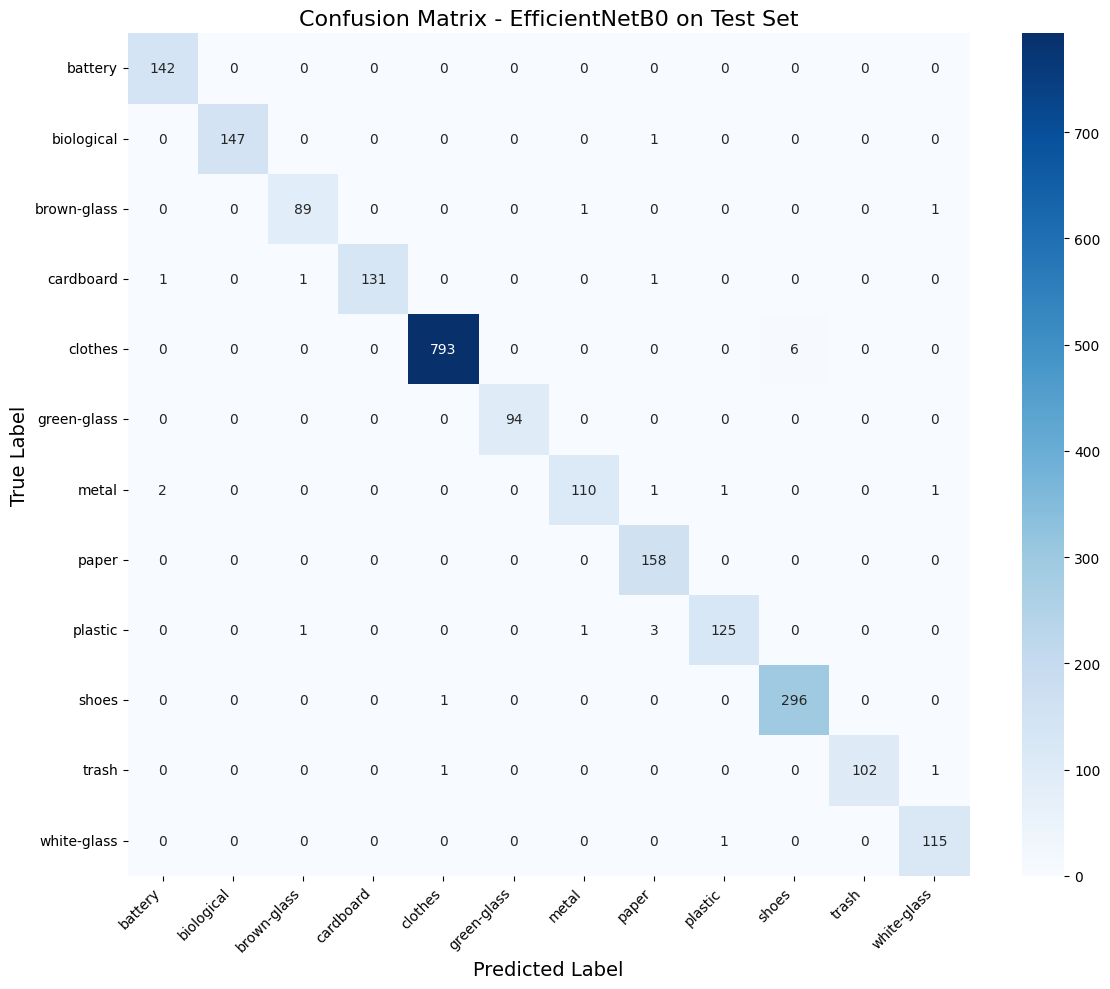

In [34]:
# Plot the confustion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Confusion Matrix - EfficientNetB0 on Test Set", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

**Predict Sample Image**

In [45]:
# Define a function to predict new test sample
def show_prediction_sample(idx, model, paths, labels, class_names):

    img_path = paths[idx]
    true_label = labels[idx]

    # Load and preprocess image the same way as training
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)

    # Save original image for visualization
    img_display = img_array.astype("uint8")

    # Preprocess for model prediction
    img_array = tf.expand_dims(img_array, 0)   # batch dimension
    img_array = tf.cast(img_array, tf.float32)

    # EfficientNet requires preprocess_input
    img_preprocessed = convnext_preprocess(img_array)

    # Predict
    preds = model.predict(img_preprocessed, verbose=0)
    pred_class_idx = np.argmax(preds)
    pred_class_name = class_names[pred_class_idx]

    # Get the higest probab
    confidence = float(np.max(preds))

    # Plot the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img_display)
    plt.axis("off")

    # Title with true + predicted
    plt.title(
        f"True: {class_names[true_label]}\nPredicted: {pred_class_name}",
        fontsize=12,
        color="green" if pred_class_idx == true_label else "red",
    )
    plt.show()

    return pred_class_name, confidence

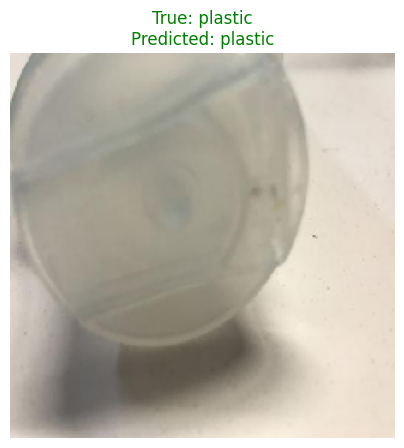

('plastic', 0.9991238713264465)

In [49]:
# Randomly select a sample
i = random.randint(0, len(paths_test)-1)
show_prediction_sample(i, model, paths_test, labels_test, class_names)